In [65]:
import pandas as pd
import numpy as np
import re
import nltk
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score

In [23]:
df = pd.read_csv('justice.csv')

## Dropping null values

In [27]:
df.dropna(inplace=True)

In [28]:
df.head()

,Unnamed: 0,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area
1,1,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,True,majority opinion,reversed/remanded,Civil Rights
2,2,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,True,majority opinion,reversed/remanded,Due Process
3,3,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,True,majority opinion,reversed/remanded,Civil Rights
4,4,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,True,majority opinion,vacated/remanded,First Amendment
5,5,50644,Kleindienst v. Mandel,https://api.oyez.org/cases/1971/71-16,71-16,1971,"Richard G. Kleindienst, Attorney General of th...","Ernest E. Mandel, et al.",<p>Ernest E. Mandel was a Belgian professional...,2282,6,3,True,majority opinion,reversed,First Amendment


## Spilitting dataset in different datasets

In [39]:
df_cat = df[['disposition', 'decision_type']]
df_cat.reset_index(drop=True, inplace=True)
df_cat.head()

,disposition,decision_type
0,reversed/remanded,majority opinion
1,reversed/remanded,majority opinion
2,reversed/remanded,majority opinion
3,vacated/remanded,majority opinion
4,reversed,majority opinion


In [47]:
df_fpw = df['first_party_winner']
df_fpw.reset_index(drop=True, inplace=True)
df_fpw.head()

0    True
1    True
2    True
3    True
4    True
Name: first_party_winner, dtype: object

In [43]:
df_nlp = df['facts']
df_nlp.reset_index(drop=True, inplace=True)
df_nlp.head()

0    <p>Joan Stanley had three children with Peter ...
1    <p>John Giglio was convicted of passing forged...
2    <p>The Idaho Probate Code specified that "male...
3    <p>Miller, after conducting a mass mailing cam...
4    <p>Ernest E. Mandel was a Belgian professional...
Name: facts, dtype: object

In [44]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df_fpw= label_encoder.fit_transform(df_fpw)

In [48]:
df_target = pd.DataFrame(df_fpw, columns=['first_party_winner'])
df_target

,first_party_winner
0,True
1,True
2,True
3,True
4,True
...,...
3093,True
3094,True
3095,False
3096,True


In [50]:
frames = [df_cat, df_target]
df_concat = pd.concat(frames, axis=1, join='inner')
df_concat

,disposition,decision_type,first_party_winner
0,reversed/remanded,majority opinion,True
1,reversed/remanded,majority opinion,True
2,reversed/remanded,majority opinion,True
3,vacated/remanded,majority opinion,True
4,reversed,majority opinion,True
...,...,...,...
3093,reversed/remanded,majority opinion,True
3094,reversed/remanded,majority opinion,True
3095,affirmed,majority opinion,False
3096,vacated/remanded,majority opinion,True


In [51]:
df_nlp1 = pd.DataFrame(df_nlp, columns=['facts'])

In [52]:
df_nlp1['facts'] = df_nlp1['facts'].str.replace(r'<[^<>]*>', '', regex=True)
df_nlp1

,facts
0,Joan Stanley had three children with Peter Sta...
1,John Giglio was convicted of passing forged mo...
2,"The Idaho Probate Code specified that ""males m..."
3,"Miller, after conducting a mass mailing campai..."
4,Ernest E. Mandel was a Belgian professional jo...
...,...
3093,For over a century after the Alaska Purchase i...
3094,"Refugio Palomar-Santiago, a Mexican national, ..."
3095,Tarahrick Terry pleaded guilty to one count of...
3096,Joshua James Cooley was parked in his pickup t...


## Cleaning and Tokenization

In [53]:
corpus = df_nlp1["facts"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))

In [54]:
ps = nltk.stem.porter.PorterStemmer()
lem = nltk.stem.wordnet.WordNetLemmatizer()

In [55]:
lst_stopwords = nltk.corpus.stopwords.words("english")

In [58]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [59]:
df_nlp1["facts_clean"] = df_nlp1["facts"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False,
                                            flg_lemm=True, lst_stopwords=lst_stopwords))

In [60]:
df_nlp1

,facts,facts_clean
0,Joan Stanley had three children with Peter Sta...,joan stanley three child peter stanley stanley...
1,John Giglio was convicted of passing forged mo...,john giglio convicted passing forged money ord...
2,"The Idaho Probate Code specified that ""males m...",idaho probate code specified male must preferr...
3,"Miller, after conducting a mass mailing campai...",miller conducting mass mailing campaign advert...
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel belgian professional journalis...
...,...,...
3093,For over a century after the Alaska Purchase i...,century alaska purchase 1867 federal governmen...
3094,"Refugio Palomar-Santiago, a Mexican national, ...",refugio palomarsantiago mexican national grant...
3095,Tarahrick Terry pleaded guilty to one count of...,tarahrick terry pleaded guilty one count posse...
3096,Joshua James Cooley was parked in his pickup t...,joshua james cooley parked pickup truck side r...


In [62]:
df_nlp2 = pd.concat([df_nlp1,df_target['first_party_winner']],axis=1, join='inner')

In [63]:
df_nlp2.head()

,facts,facts_clean,first_party_winner
0,Joan Stanley had three children with Peter Sta...,joan stanley three child peter stanley stanley...,True
1,John Giglio was convicted of passing forged mo...,john giglio convicted passing forged money ord...,True
2,"The Idaho Probate Code specified that ""males m...",idaho probate code specified male must preferr...,True
3,"Miller, after conducting a mass mailing campai...",miller conducting mass mailing campaign advert...,True
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel belgian professional journalis...,True


In [64]:
df_nlp2["first_party_winner"].value_counts()

True     2067
False    1031
Name: first_party_winner, dtype: int64

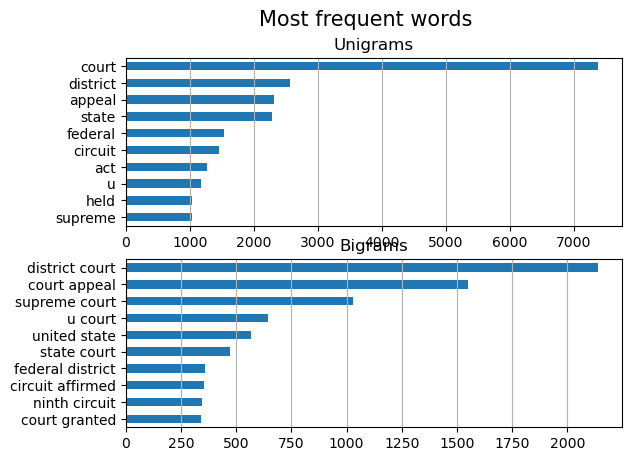

In [66]:
y = 1
corpus = df_nlp2[df_nlp2["first_party_winner"]== y]["facts_clean"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.suptitle("Most frequent words", fontsize=15)

dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                       columns=["Word","Freq"])
dtf_uni.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax[0], 
                  legend=False).grid(axis='x')
ax[0].set(ylabel=None)
    
## bigrams
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                      columns=["Word","Freq"])
dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                   string for string in x) )
dtf_bi.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Bigrams", ax=ax[1],
                  legend=False).grid(axis='x')
ax[1].set(ylabel=None)
plt.show()

In [70]:
import wordcloud

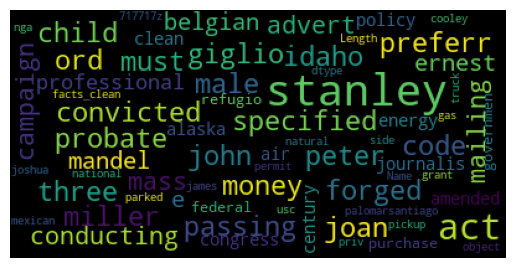

In [71]:
wc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc = wc.generate(str(corpus))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

In [72]:
import gensim.downloader as gensim_api
import gensim
import seaborn as sns

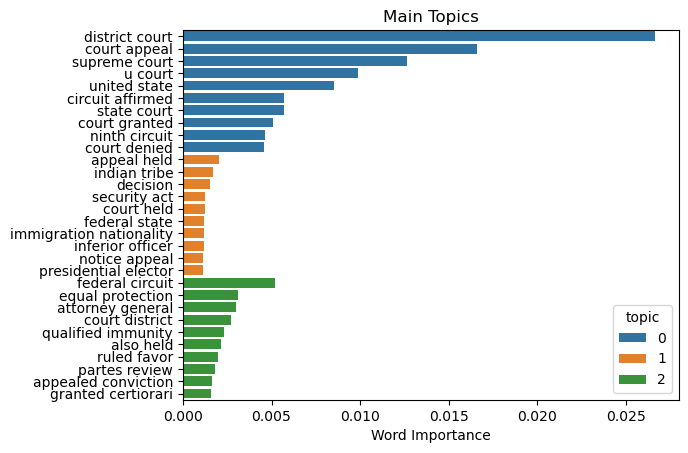

In [74]:
y = 1
corpus = df_nlp2[df_nlp2["first_party_winner"]==y]["facts_clean"]
## pre-process corpus
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i + 2]) for i in range(0, 
                     len(lst_words), 2)]
    lst_corpus.append(lst_grams)## map words to an id
id2word = gensim.corpora.Dictionary(lst_corpus)## create dictionary word:freq
dic_corpus = [id2word.doc2bow(word) for word in lst_corpus] ## train LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=dic_corpus, id2word=id2word, num_topics=7, 
            random_state=123, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
   
## output
lst_dics = []
for i in range(0,3):
    lst_tuples = lda_model.get_topic_terms(i)
    for tupla in lst_tuples:
        lst_dics.append({"topic":i, "id":tupla[0], 
                         "word":id2word[tupla[0]], 
                         "weight":tupla[1]})
dtf_topics = pd.DataFrame(lst_dics, 
                         columns=['topic','id','word','weight'])

## plot
fig, ax = plt.subplots()
sns.barplot(y="word", x="weight", hue="topic", data=dtf_topics, dodge=False, ax=ax).set_title('Main Topics')
ax.set(ylabel="", xlabel="Word Importance")
plt.show()

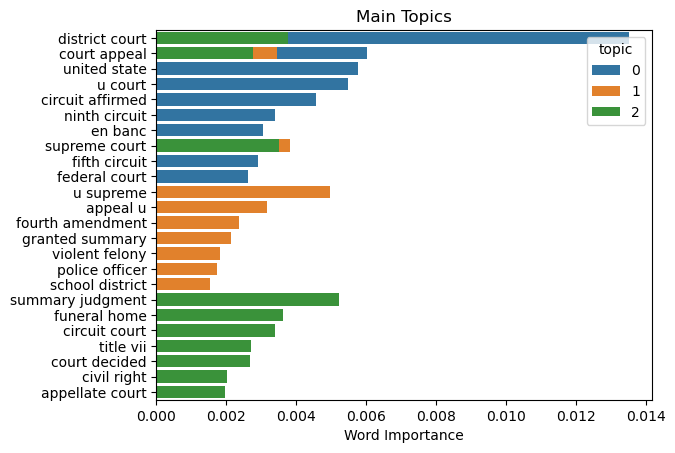

In [76]:
y = 0
corpus = df_nlp2[df_nlp2["first_party_winner"]==y]["facts_clean"]
## pre-process corpus
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i + 2]) for i in range(0, 
                     len(lst_words), 2)]
    lst_corpus.append(lst_grams)## map words to an id
id2word = gensim.corpora.Dictionary(lst_corpus)## create dictionary word:freq
dic_corpus = [id2word.doc2bow(word) for word in lst_corpus] ## train LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=dic_corpus, id2word=id2word, num_topics=7,
            random_state=123, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
   
## output
lst_dics = []
for i in range(0,3):
    lst_tuples = lda_model.get_topic_terms(i)
    for tupla in lst_tuples:
        lst_dics.append({"topic":i, "id":tupla[0], 
                         "word":id2word[tupla[0]], 
                         "weight":tupla[1]})
dtf_topics = pd.DataFrame(lst_dics, 
                         columns=['topic','id','word','weight'])

## plot
fig, ax = plt.subplots()
sns.barplot(y="word", x="weight", hue="topic", data=dtf_topics, dodge=False, ax=ax).set_title('Main Topics')
ax.set(ylabel="", xlabel="Word Importance")
plt.show()

In [77]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

In [78]:
vectorizer = CountVectorizer()

In [80]:
df_nlp2 = pd.concat([df_nlp1,df_target['first_party_winner']],axis=1, join='inner')

In [91]:
xfeatures = df_nlp2['facts_clean']
ylabel = df_nlp2['first_party_winner']
ylabel = ylabel.astype('int')

## Training Testing and Modelling

In [92]:
X_train, X_test, y_train, y_test = train_test_split(xfeatures, ylabel, test_size=0.25)

In [93]:
pipe = Pipeline(steps=[('cv',CountVectorizer()),('lr',LogisticRegression(solver='liblinear'))])

In [94]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('cv', CountVectorizer()),
                ('lr', LogisticRegression(solver='liblinear'))])

In [95]:
pipe.score(X_test,y_test)

0.6412903225806451

In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [97]:
pipe1= Pipeline(steps=[('cv',CountVectorizer()),('rf',RandomForestClassifier())])

In [98]:
pipe1.fit(X_train,y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('rf', RandomForestClassifier())])

In [99]:
pipe1.score(X_train,y_train)

1.0

In [100]:
pipe1.score(X_test,y_test)

0.6683870967741935

In [101]:
pipe2= Pipeline(steps=[('cv',CountVectorizer()),('rf',KNeighborsClassifier(n_neighbors=3))])

In [102]:
pipe2.fit(X_train,y_train)

Pipeline(steps=[('cv', CountVectorizer()),
                ('rf', KNeighborsClassifier(n_neighbors=3))])

In [104]:
pipe2.score(X_train,y_train)

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.7589324149806285

In [105]:
pipe2.score(X_test,y_test)

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.6464516129032258

In [106]:
df_nl1=pd.concat([df_nlp2,df_cat],axis=1,join='inner')

In [107]:
df_nl1

,facts,facts_clean,first_party_winner,disposition,decision_type
0,Joan Stanley had three children with Peter Sta...,joan stanley three child peter stanley stanley...,True,reversed/remanded,majority opinion
1,John Giglio was convicted of passing forged mo...,john giglio convicted passing forged money ord...,True,reversed/remanded,majority opinion
2,"The Idaho Probate Code specified that ""males m...",idaho probate code specified male must preferr...,True,reversed/remanded,majority opinion
3,"Miller, after conducting a mass mailing campai...",miller conducting mass mailing campaign advert...,True,vacated/remanded,majority opinion
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel belgian professional journalis...,True,reversed,majority opinion
...,...,...,...,...,...
3093,For over a century after the Alaska Purchase i...,century alaska purchase 1867 federal governmen...,True,reversed/remanded,majority opinion
3094,"Refugio Palomar-Santiago, a Mexican national, ...",refugio palomarsantiago mexican national grant...,True,reversed/remanded,majority opinion
3095,Tarahrick Terry pleaded guilty to one count of...,tarahrick terry pleaded guilty one count posse...,False,affirmed,majority opinion
3096,Joshua James Cooley was parked in his pickup t...,joshua james cooley parked pickup truck side r...,True,vacated/remanded,majority opinion


In [108]:
xfeatures1 = df_nl1[['facts_clean','decision_type','disposition']]
ylabel1 = df_nl1['first_party_winner']

In [109]:
df_cat1 = pd.get_dummies(df_cat['decision_type'])

In [110]:
df_cat2 = pd.get_dummies(df_cat['disposition'])

In [111]:
df_cat3=pd.concat([df_cat2,df_cat1],axis=1,join='inner')

In [112]:
df_cat3.columns

Index(['affirmed', 'none', 'reversed', 'reversed in-part',
       'reversed in-part/remanded', 'reversed/remanded', 'vacated',
       'vacated in-part/remanded', 'vacated/remanded',
       'dismissal - improvidently granted', 'dismissal - moot',
       'dismissal - other', 'equally divided', 'majority opinion',
       'opinion of the court', 'per curiam', 'plurality opinion'],
      dtype='object')

In [113]:
df_cat3=pd.concat([df_cat3,df_nl1['first_party_winner']],axis=1,join='inner')

In [114]:
vectorize=CountVectorizer()

In [115]:
count_matrix = vectorize.fit_transform(df_nl1['facts_clean'])
count_array = count_matrix.toarray()
data_final = pd.DataFrame(data=count_array,columns = vectorize.get_feature_names())

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [116]:
data_final = pd.concat([data_final,df_cat3],axis=1,join='inner')

In [117]:
data_final

,011119,0125,01657,019,02,036539,04,041352,041581,045323,...,vacated/remanded,dismissal - improvidently granted,dismissal - moot,dismissal - other,equally divided,majority opinion,opinion of the court,per curiam,plurality opinion,first_party_winner
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,True
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,True
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,True
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,True
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3093,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,True
3094,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,True
3095,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,False
3096,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,True


In [118]:
X_train, X_test, y_train, y_test = train_test_split(data_final.drop(columns=['first_party_winner']),
                                                    data_final['first_party_winner'], 
                                                    test_size=0.3,random_state=10)

In [119]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_final = scaler.fit_transform(data_final)

In [120]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=200, random_state=0)
lda_data = lda.fit_transform(X_train)

In [121]:
lda_data_train = pd.DataFrame(data=lda_data)

In [122]:
lda_data_test = pd.DataFrame(data=lda.transform(X_test))

In [123]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [8,10,12,14],
    'max_features': [60,70,80,90,100],
    'min_samples_leaf': [2, 3, 4],
    'n_estimators': [100, 200, 300]
}# Create a based model
rf = RandomForestClassifier()# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [125]:
y_train = y_train.astype('int')

In [126]:
grid_search.fit(lda_data_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 180 candidates, totalling 540 fits


{'max_depth': 8,
 'max_features': 90,
 'min_samples_leaf': 2,
 'n_estimators': 300}

In [127]:
rand=RandomForestClassifier(max_depth= 8, max_features = 100, min_samples_leaf = 2, n_estimators = 200)

In [128]:
rand.fit(lda_data_train,y_train)

RandomForestClassifier(max_depth=8, max_features=100, min_samples_leaf=2,
                       n_estimators=200)

In [129]:
rand.score(lda_data_train,y_train)

0.7001845018450185

In [131]:
y_test = y_test.astype('int')

In [132]:
rand.score(lda_data_test,y_test)

0.6741935483870968

In [133]:
from sklearn.metrics import f1_score

In [134]:
y_pred1 = rand.predict(lda_data_test)
f1_score(y_test, y_pred1)

0.8031189083820662

In [135]:
model = XGBClassifier()
model.fit(lda_data_train, y_train)
y_pred = model.predict(lda_data_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
f1_score(y_test, y_pred1)

Accuracy: 65.05%


0.8031189083820662

In [136]:
knn=KNeighborsClassifier(n_neighbors=7)

In [137]:
knn.fit(lda_data_train,y_train)

KNeighborsClassifier(n_neighbors=7)

In [138]:
knn.score(lda_data_train,y_train)

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.7061808118081181

In [139]:
knn.score(lda_data_test,y_test)

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.6365591397849463

In [140]:
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

In [141]:
n_unique_words = 10000 # cut texts after this number of words
maxlen = 2000
batch_size = 32

In [142]:
model = Sequential()
model.add(Embedding(n_unique_words, 128, input_length=maxlen))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])